In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



## Extract list of all articles on Plato from contents page

In [2]:
def _scrape(url):
    response = requests.get(url) # get HTML content
    soup = BeautifulSoup(response.content, 'html.parser') # parse
    hyperlinks = soup.find_all('a', href=lambda href: href and href.startswith('entries'))
    urls = [hyperlink.get('href') for hyperlink in hyperlinks] # Extract the URLs from the hyperlinks
    return urls

In [3]:
contents_list = _scrape("https://plato.stanford.edu/contents.html")

In [4]:
contents = pd.DataFrame(contents_list, columns=['href'])
contents['topic_name'] = contents['href'].apply(lambda x: x.split('/')[1])
contents['topic_name'] = contents['topic_name'].str.replace('-', ' ')
contents['url'] = contents['href'].apply(lambda x: 'https://plato.stanford.edu/' + x)
contents.head(1)

,href,topic_name,url
0,entries/abduction/,abduction,https://plato.stanford.edu/entries/abduction/


## Extract keywords from each URL

remove common words

In [108]:
original_list = contents["topic_name"].tolist()
words_to_remove = {'analysis','argument', 'belief','properties','property','reference', 'respect','time'}

def _remove(word_list):
    for word in words_to_remove:
        while word in word_list:
            word_list.remove(word)
    return word_list

topic_keywords_list = _remove(original_list)

# test

In [111]:
test = pd.DataFrame({
'url': ["https://plato.stanford.edu/entries/abduction/",
       "https://plato.stanford.edu/entries/skepticism/",
       "https://plato.stanford.edu/entries/scientific-realism/"],
'topic_name': ["abduction",
              "skepticism",
              "scientific realism"]
})
test["url"]

0        https://plato.stanford.edu/entries/abduction/
1       https://plato.stanford.edu/entries/skepticism/
2    https://plato.stanford.edu/entries/scientific-...
Name: url, dtype: object

In [112]:
test.values

array([['https://plato.stanford.edu/entries/abduction/', 'abduction'],
       ['https://plato.stanford.edu/entries/skepticism/', 'skepticism'],
       ['https://plato.stanford.edu/entries/scientific-realism/',
        'scientific realism']], dtype=object)

In [113]:
def _keywords(topic_name, url_input, keyword_input):
    found_keywords_list = [] # make empty list
    response = requests.get(url_input) #get html
    soup = BeautifulSoup(response.content, 'html.parser') #parse
    text = soup.get_text()
    for keyword in keyword_input:
        if keyword != topic_name:
            if keyword in text:
                found_keywords_list.append(keyword) 
    counts = {}
    for element in found_keywords_list: # consider replacing this with Counter
        if element in counts:
            counts[element] += 1
        else:
            counts[element] = 1
    sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    filtered_list = list(sorted_counts.keys())[:10] ##### toggle
    if len(filtered_list) < 2:
        return(found_keywords_list)
    else:
        return(filtered_list)

In [114]:
def _rows(df):
    nested_list = []
    for index, row in tqdm(df.iterrows(), desc='Processing rows...'):
        output = _keywords(row["topic_name"], row['url'], topic_keywords_list)
        nested_list.append({row['topic_name']: output})
    return nested_list

In [115]:
testresult = _rows(test)

Processing rows...: 0it [00:00, ?it/s]

In [116]:
testresult

[{'abduction': ['skepticism',
   'existence',
   'confirmation',
   'scientific explanation',
   'scientific realism',
   'abilities',
   'action',
   'attention',
   'broad',
   'change']},
 {'skepticism': ['possible worlds',
   'existence',
   'ceteris paribus',
   'logical truth',
   'action',
   'assertion',
   'attention',
   'ayer',
   'blame',
   'broad']},
 {'scientific realism': ['skepticism',
   'possible worlds',
   'abduction',
   'existence',
   'confirmation',
   'constructive empiricism',
   'continuity',
   'logical empiricism',
   'scientific explanation',
   'incommensurability']}]

In [117]:
result_list = []
for d in testresult:
    for k, v in d.items():
        row = [k] + v + [None] * (10 - len(v))
        result_list.append(row)

df_result = pd.DataFrame(result_list, columns=['topic_name'] + [f'output_{i+1}' for i in range(10)])

In [118]:
df_result

,topic_name,output_1,output_2,output_3,output_4,output_5,output_6,output_7,output_8,output_9,output_10
0,abduction,skepticism,existence,confirmation,scientific explanation,scientific realism,abilities,action,attention,broad,change
1,skepticism,possible worlds,existence,ceteris paribus,logical truth,action,assertion,attention,ayer,blame,broad
2,scientific realism,skepticism,possible worlds,abduction,existence,confirmation,constructive empiricism,continuity,logical empiricism,scientific explanation,incommensurability


In [119]:
result_list = []
for i in range(len(df_result)):
    nested_dict = {df_result.iloc[i]['topic_name']: [v for v in df_result.iloc[i].values[1:11] if v is not None]}
    result_list.append(nested_dict)

In [120]:
result_list

[{'abduction': ['skepticism',
   'existence',
   'confirmation',
   'scientific explanation',
   'scientific realism',
   'abilities',
   'action',
   'attention',
   'broad',
   'change']},
 {'skepticism': ['possible worlds',
   'existence',
   'ceteris paribus',
   'logical truth',
   'action',
   'assertion',
   'attention',
   'ayer',
   'blame',
   'broad']},
 {'scientific realism': ['skepticism',
   'possible worlds',
   'abduction',
   'existence',
   'confirmation',
   'constructive empiricism',
   'continuity',
   'logical empiricism',
   'scientific explanation',
   'incommensurability']}]

In [121]:
def _graph(output):
    graph_dict = {}
    for d in output:
        for key, value in d.items():
            if key not in graph_dict:
                graph_dict[key] = []
            for node in value:
                if node not in graph_dict:
                    graph_dict[node] = []
                graph_dict[key].append(node)
                graph_dict[node].append(key)
    return nx.Graph(graph_dict)

In [122]:
G = _graph(result_list)

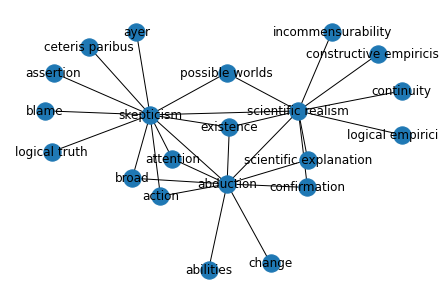

In [123]:
# Draw the graph
nx.draw(G, with_labels=True)

# Show the graph
plt.show()